# Dear ML Model, Please Multiply

This notebook shows how ML models can learn to approximately multiply two numbers, even when the data is noisy.

### Basics

A typical ML task is to estimate a function $f$ 
$$
    y = f(x_1, x_2, \dots) + \varepsilon
$$
as good as possible by $\hat f$ from data. Afterward, we can use $\hat f$ to 

- gain insights on the relationship between $x_i$ and $y$ and
- to make predictions based on $x_i$.

The specific steps to find $\hat f$ depend on the assumed structural form of $f$ and the optimization algorithm used to determine $\hat f$. 

### Some examples

- **Linear regression**: $f$ is assumed to be linear in its parameters and $\hat f$ is found by least-squares.
- **Generalized linear model**: $g(f)$ is linear and $\hat f$ is found by iteratively reweighted least-squares.
- **Neural net**: $f$ is a composition of linear and non-linear functions, found by auto-differentiation-based gradient descent.
- **Decision tree**: $f$ is a binary decision tree, i.e. a collection of yes/no questions calculated by recursion.
- **Random forest**: $f$ is the average of randomized decision trees.
- **Gradient boosting**: $f$ is the average of decision trees, calculated sequentially. Each tree tries to fix the mistakes of the previous ones.

### Outlook

In this notebook, we will use neural nets and gradient boosting to learn noisy multiplication of two numbers $x_1$ and $x_2$, i.e.
$$
    y = f(x_1, x_2) + \varepsilon = x_1 \cdot x_2 + \varepsilon, 
$$
with $\varepsilon\sim N(0,1)$.

## Generate noisy data

Let's generate one million independent observations of above random process.

In [1]:
# Load modules
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

,x1,x2,y
0,-1.427959,-0.909703,2.914672
1,2.521623,-3.973049,-9.736590
2,1.307314,-1.002808,-1.534397
3,-6.998346,-0.479178,3.621836
4,-5.852353,-1.723083,10.453152


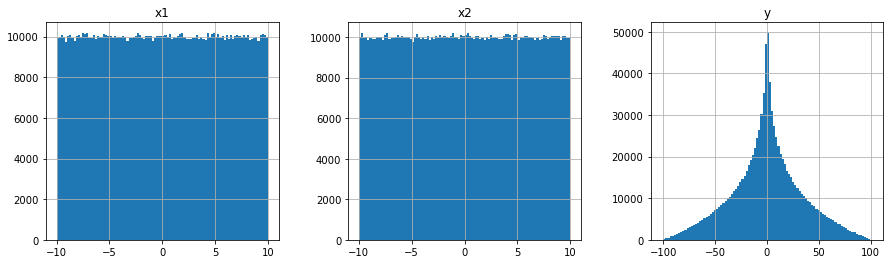

In [2]:
# Gernerate n observations
np.random.seed(1901)
n = 1_000_000 # 10_000_000
df = pd.DataFrame(np.random.uniform(-10, 10, size=(n, 2)), columns=['x1', 'x2'])
df['y'] = df.x1 * df.x2 + np.random.normal(scale=1, size=(n, ))
df.hist(bins=100, layout=(1, 3), figsize=(15, 4))
df.head()

### Training/Validation split

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    df.drop('y', axis=1), 
    df.y, 
    train_size=0.9, 
    random_state=525
)

## Neural Net

Can a neural net predict the result of the (noisy) multiplication if it fed the two inputs?

We start with the most simple neural net (no hidden layers) and then, step by step, add more neurons and/or more hidden layers. 
To do so, we rely on Google's [Keras/Tensorflow](https://www.tensorflow.org/guide/keras/sequential_model?hl=en).

It is up to you, dear user, to select the specific architecture. 

In [4]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense

# Plot history (dropping the first m burn-in epochs)
def plot_history(h, drop_m=0):
    h = pd.DataFrame(h.history.history)
    h['epoch'] = np.arange(len(h.index)) + 1
    h = h.iloc[drop_m:]
    plt.plot(h.epoch, h.loss, label='Training')
    plt.plot(h.epoch, h.val_loss, label='Validation')
    plt.legend()
    
# Callbacks to stop if validation performance stops to improve and to lower the learning-rate if appropriate.
early_stop = tf.keras.callbacks.EarlyStopping(patience=10, mode='min')
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.2)
cb = [early_stop, reduce_lr]

### Architecture

In [5]:
# Neural net structure (play with architecture)
def fresh_neural_net():
    m = keras.Sequential()
    m.add(Dense(20, activation='tanh', input_shape=(2, )))
    m.add(Dense(1, activation='linear'))
    m.compile(loss='mse', optimizer=keras.optimizers.Nadam(lr=0.05))
    return m

# Create new net
neural_net = fresh_neural_net()
neural_net.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                60        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________


### Stochastic gradient descend until model does not get better anymore

In [6]:
neural_net.fit(
    X_train,
    y_train,
    batch_size=10000, 
    epochs=1000, 
    validation_data = (X_valid, y_valid),
    callbacks=cb,
    verbose=1)

Train on 900000 samples, validate on 100000 samples
Epoch 1/1000
900000/900000 [==============================] - 1s 1us/sample - loss: 491.1790 - val_loss: 151.7956
Epoch 2/1000
900000/900000 [==============================] - 0s 0us/sample - loss: 107.6255 - val_loss: 69.3005
Epoch 3/1000
900000/900000 [==============================] - 0s 0us/sample - loss: 53.3086 - val_loss: 40.3090
Epoch 4/1000
900000/900000 [==============================] - 0s 0us/sample - loss: 34.2494 - val_loss: 23.5082
Epoch 5/1000
900000/900000 [==============================] - 0s 0us/sample - loss: 26.2585 - val_loss: 21.0851
Epoch 6/1000
900000/900000 [==============================] - 0s 0us/sample - loss: 20.1638 - val_loss: 20.2738
Epoch 7/1000
900000/900000 [==============================] - 0s 0us/sample - loss: 18.1630 - val_loss: 23.0464
Epoch 8/1000
900000/900000 [==============================] - 0s 0us/sample - loss: 14.3309 - val_loss: 23.8731
Epoch 9/1000
900000/900000 [=====================

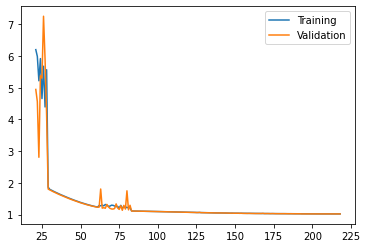

In [7]:
plot_history(neural_net, 20)

### Test model

In [8]:
neural_net.predict([[-3, -8]])

array([[24.06003]], dtype=float32)

### Extrapolation with numbers outside [-10, 10]?

In [9]:
neural_net.predict([[4, 40]])

array([[8.776615]], dtype=float32)

The model works, but only within the range of samples available. Extrapolation is not possible without manual feature engineering.

## Gradient boosting

Neural nets are especially successful with text, image, and sound data. For tabular data, other methods like gradient boosting are often better and easier to use. Hoever, since the normal person has never heard of GLMs, random forests or gradient boosting, it is easier to mention neural nets if someone asks about what we do...

Here, we fit a [LightGBM model](https://lightgbm.readthedocs.io/en/latest), a gradient boosting algorithm implementation by Microsoft.

In [10]:
import lightgbm as lgb

# Internal data handler
dtrain = lgb.Dataset(X_train, y_train)
dvalid = lgb.Dataset(X_valid, y_valid)

# Parameters
params = {
    'learning_rate': 0.2,
    'num_leaves': 63,
    'min_child_samples': 10,
    'objective': 'mse'
}

# Fit until validation performance starts to deteriorate
fit = lgb.train(
    params, 
    train_set=dtrain,
    early_stopping_rounds=20,
    num_boost_round=10000,
    valid_sets=dvalid,
    verbose_eval=100
)

Training until validation scores don't improve for 20 rounds
[100]	valid_0's l2: 1.23496
[200]	valid_0's l2: 1.12553
[300]	valid_0's l2: 1.09257
[400]	valid_0's l2: 1.07608
[500]	valid_0's l2: 1.06854
[600]	valid_0's l2: 1.06417
[700]	valid_0's l2: 1.06178
[800]	valid_0's l2: 1.06043
Early stopping, best iteration is:
[876]	valid_0's l2: 1.05976


In [11]:
fit.predict([[-3, -8]])

array([24.15381159])

### Extrapolation with numbers outside [-10, 10]?

In [12]:
fit.predict([[20, 3]])

array([29.82848241])

## Reality?
- More than two input variables
- Missing values
- Outliers and data errors
- Special data structure (clusters, time series, spatial, ...)
- Extrapolation